In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from src.dataset import get_data_loaders
from src.config import *

In [3]:
print(f"Using device: {DEVICE}")

# 1. Load Data
print("Loading data...")
train_loader, val_loader, label_encoder_obj = get_data_loaders(
    data_dir=DATA_DIR,
    csv_path=TRAIN_CSV_PATH,
    target_label_col=TARGET_LABEL_COLUMN,
    batch_size=BATCH_SIZE,
    val_split_size=VALIDATION_SPLIT_SIZE,
    random_state=RANDOM_STATE,
    label_encoder_path=LABEL_ENCODER_PATH
)
print("Data loaded.")

Using device: cpu
Loading data...
Reading audio file paths and labels from d:\BirdCLEF_2025\data\metadata\train.csv...
Found 28564 existing audio files with labels.
LabelEncoder saved to d:\BirdCLEF_2025\models\label_encoder.joblib
Number of unique labels found: 206
Total files for training/validation: 28564
Training samples: 22851, Validation samples: 5713
Data loaded.



--- Testing train_loader ---
Total training samples: 22851
Number of batches in train_loader: 715

Fetching one batch from train_loader...


d:\BirdCLEF_2025\venv_bird\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Successfully fetched one batch.
Inputs batch shape: torch.Size([32, 3, 128, 157])
Labels batch shape: torch.Size([32])
Inputs dtype: torch.float32
Labels dtype: torch.int64
Min label in batch: 0
Max label in batch: 205
Number of classes according to LabelEncoder: 206
Inputs device: cpu


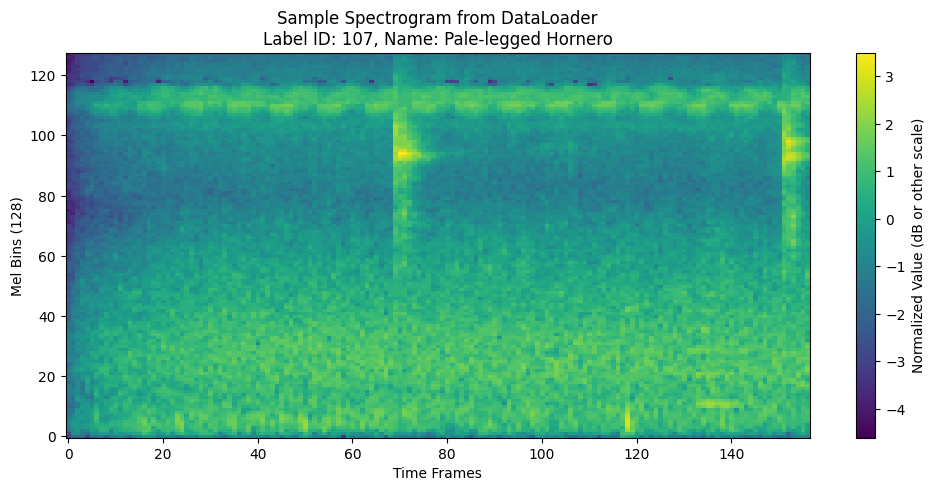

In [4]:
# 2. Test the DataLoader (e.g., train_loader)

if 'train_loader' in locals() and train_loader is not None:
    print(f"\n--- Testing train_loader ---")

    # Check the number of samples and batches
    try:
        num_train_samples = len(train_loader.dataset)
        num_train_batches = len(train_loader)
        print(f"Total training samples: {num_train_samples}")
        print(f"Number of batches in train_loader: {num_train_batches}")

        if num_train_samples == 0:
            print("WARNING: train_loader.dataset is empty! No data was loaded.")
        elif num_train_batches == 0:
            print("WARNING: train_loader has 0 batches! This might happen if dataset is smaller than batch size or empty.")

    except Exception as e:
        print(f"Error getting loader/dataset length: {e}")


    # Get one batch of data
    try:
        print("\nFetching one batch from train_loader...")
        inputs, labels = next(iter(train_loader)) # Get the first batch

        print(f"Successfully fetched one batch.")
        # Check shapes
        print(f"Inputs batch shape: {inputs.shape}")
        # Expected: (BATCH_SIZE, 3, N_MELS, FIXED_LENGTH_FRAMES)
        # e.g., (32, 3, 128, 157) if BATCH_SIZE=32, N_MELS=128, FIXED_LENGTH_FRAMES computed from 5s audio

        print(f"Labels batch shape: {labels.shape}")
        # Expected: (BATCH_SIZE,) e.g., (32,)

        # Check dtypes
        print(f"Inputs dtype: {inputs.dtype}")  # Expected: torch.float32
        print(f"Labels dtype: {labels.dtype}")  # Expected: torch.int64 (long)

        # Check label range (important!)
        min_label = labels.min().item()
        max_label = labels.max().item()
        print(f"Min label in batch: {min_label}")
        print(f"Max label in batch: {max_label}")

        # The maximum label should be less than the number of classes
        # Number of classes can be obtained from the label_encoder
        num_actual_classes = len(label_encoder_obj.classes_)
        print(f"Number of classes according to LabelEncoder: {num_actual_classes}")
        if max_label >= num_actual_classes:
            print(f"ERROR: Max label in batch ({max_label}) is out of bounds for {num_actual_classes} classes!")
        if min_label < 0:
            print(f"ERROR: Min label in batch ({min_label}) is negative! This shouldn't happen with LabelEncoder.")

        # Check if inputs are on the correct device (optional, but good for GPU usage)
        print(f"Inputs device: {inputs.device}") # Should match config.DEVICE if processed correctly

        # (Optional) Visualize a Spectrogram from the batch
        import matplotlib.pyplot as plt

        # Select the first spectrogram from the batch, and its first channel (since we repeated it)
        # Ensure the input tensor is on CPU and converted to NumPy for plotting
        sample_spectrogram = inputs[0][0].cpu().numpy()
        sample_label_id = labels[0].item()
        sample_label_name = label_encoder_obj.inverse_transform([sample_label_id])[0]


        plt.figure(figsize=(12, 5))
        plt.imshow(sample_spectrogram, aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(label='Normalized Value (dB or other scale)')
        plt.xlabel("Time Frames")
        plt.ylabel(f"Mel Bins ({N_MELS})")
        plt.title(f"Sample Spectrogram from DataLoader\nLabel ID: {sample_label_id}, Name: {sample_label_name}")
        plt.show()

    except StopIteration:
        print("ERROR: Could not fetch a batch. The DataLoader is empty or exhausted.")
        if len(train_loader.dataset) > 0 and len(train_loader) == 0 :
             print("This can happen if all samples in the first (and only) batch failed processing due to the collate_fn filtering them out.")
        elif len(train_loader.dataset) == 0:
             print("The dataset itself is empty.")
    except Exception as e:
        print(f"An error occurred while inspecting the batch: {e}")
        import traceback
        traceback.print_exc()

else:
    print("train_loader was not created successfully. Cannot run tests.")

# You can repeat similar tests for val_loader if needed
# if 'val_loader' in locals() and val_loader is not None:
#     print(f"\n--- Testing val_loader ---")
#     inputs_val, labels_val = next(iter(val_loader))
#     print(f"Validation inputs batch shape: {inputs_val.shape}")
#     print(f"Validation labels batch shape: {labels_val.shape}")
#     # ... etc.